In [60]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

C:\Users\juyeo\AppData\Local\Temp\ipykernel_34416\3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [61]:
import glob
import time

import pandas as pd
import numpy as np

In [62]:
data_list = glob.glob('cluster*.csv')
data_list

['cluster_0.csv', 'cluster_1.csv', 'cluster_2.csv', 'cluster_3.csv']

In [63]:
#cluster = pd.read_csv(data_list[0])

In [64]:
pd.read_csv(data_list[3])

,시장(상점가명),방송시설,이벤트광장,테마거리,아치/조형물,공용광고판,유아놀이방어린이놀이터,고객휴게실,수유시설,물품보관함,...,0G_W,10G_W,20G_W,30G_W,40G_W,50G_W,60G_W,70GU_W,cluster_id,Y_final
0,간석자유시장,1,1,0,1,1,0,1,0,0,...,0.622903,2.916786,3.021926,4.716064,5.834104,5.615900,5.384329,3.088375,3,2.0
1,거제시장,1,0,0,0,0,0,0,0,0,...,0.489789,2.905512,3.413433,4.816278,5.750437,5.235226,4.887399,3.082731,3,0.0
2,곡천공설시장,0,0,0,1,0,0,0,0,0,...,0.688216,3.097384,4.764202,8.085699,8.983581,8.423796,7.697227,3.767531,3,0.0
3,관문상가시장,1,1,0,1,1,0,1,1,1,...,0.608967,3.293533,3.433050,5.105340,6.624334,5.713268,4.911291,2.668385,3,0.0
4,광덕시장,1,0,0,0,0,0,0,0,0,...,0.608967,3.293533,3.433050,5.105340,6.624334,5.713268,4.911291,2.668385,3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,해운대시장,1,1,0,1,1,0,1,1,0,...,0.566780,3.380379,4.228384,6.119407,6.304934,5.484718,5.185784,3.086272,3,0.0
71,호계공설시장,1,1,0,1,0,0,0,0,0,...,0.796459,3.886934,4.671404,6.698201,8.295529,8.629728,8.267131,4.278034,3,0.0
72,화봉시장(화봉종합시장),1,0,0,0,0,0,1,0,0,...,0.796459,3.886934,4.671404,6.698201,8.295529,8.629728,8.267131,4.278034,3,0.0
73,화정동서부시장,0,0,0,1,0,0,0,0,0,...,1.099877,5.187026,6.480788,9.717314,10.997227,9.273424,8.444714,4.693154,3,0.0


In [65]:
def preprocessing(cluster):
    global cluster_X
    cluster.index = cluster['시장(상점가명)'] #index 처리
    cluster = cluster.drop(['시장(상점가명)'],axis=1)
    
    cluster_X=cluster[cluster.columns[:-2]] #train test split을 위한 feature label 구분
    cluster_Y=cluster[cluster.columns[-1]]
    #cluster_Y = cluster_Y[0:]
    
    from sklearn.model_selection import train_test_split #train test split
    train_features, test_features, train_labels, test_labels = train_test_split(cluster_X,cluster_Y,test_size=0.2, random_state = 0, shuffle=False)
    print('train', train_features.shape,train_labels.shape)
    print('test', test_features.shape,test_labels.shape)
    
    from sklearn.preprocessing import MinMaxScaler #Scaling
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_train = scaler.fit_transform(train_features)
    X_test = scaler.fit_transform(test_features)
    
    return X_train, X_test, train_labels, test_labels  

In [66]:
def smoting (X_train, train_labels):
    from imblearn.over_sampling import SMOTE
    nh=1
    smote = SMOTE(random_state=42,k_neighbors=nh)
    X_resampled, y_resampled = smote.fit_resample(X_train,np.array(list(train_labels)))

    print('X_resampled : ', X_resampled.shape)
    print('y_resampled : ', len(y_resampled))
    
    return X_resampled, y_resampled

In [67]:
def df_result(param, score, logloss, df = pd.DataFrame()):
    result_list = [p for p in param]
    result_list.append(score)
    result_list.append(logloss)
    df = df.append(result_list)
    
    return df

In [68]:
from sklearn.linear_model import LogisticRegression

In [69]:
def modeling(X_resampled,X_test, y_resampled, test_labels, result = pd.DataFrame()):
    try :
        from lightgbm import LGBMClassifier
        lgbm = LGBMClassifier(n_estimators=400, learning_rate= 0.05,random_state = 42)

        from xgboost import XGBClassifier
        xgb = XGBClassifier(n_estimators=400, learning_rate= 0.05,random_state = 42,num_class=4)

        from catboost import CatBoostClassifier
        catb = CatBoostClassifier(verbose=0)

        from sklearn.ensemble import GradientBoostingClassifier
        gbc = GradientBoostingClassifier(n_estimators=400,learning_rate=0.05,random_state = 42,n_classes_int=4)

        from sklearn.ensemble import RandomForestClassifier
        rfc = RandomForestClassifier(random_state = 42)

        from sklearn.ensemble import AdaBoostClassifier
        adb = AdaBoostClassifier(n_estimators=400,learning_rate=0.05,random_state = 42)

        for model in [lgbm,xgb,catb,gbc,rfc,adb]:
            model.fit(X_resampled,y_resampled) #model fitting
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)

            #confusion = confusion_matrix(test_labels, y_pred)
            param = model.feature_importances_
            score = model.score(X_test, test_labels)

            from sklearn.metrics import log_loss
            logloss = log_loss(test_labels, y_pred_proba)

            df = df_result(param, score, logloss)
            result = pd.concat([result,df],axis=1)
            #feature_EDA(param, cluster_X)
    
    except : 
        pass
    
    return result.T

SyntaxError: invalid syntax (4134478070.py, line 7)

In [70]:
def make_result(cluster):
    try : 
        global result
        X_train, X_test, train_labels, test_labels = preprocessing(cluster)
        X_resampled, y_resampled = smoting(X_train,train_labels)
        result = modeling(X_resampled,X_test, y_resampled, test_labels)

        cluster_name = data_list[i].split('.')[0]
        model = [f'{cluster_name} LGBM',f'{cluster_name} XGB',f'{cluster_name} CATB',f'{cluster_name} GBC',f'{cluster_name} RFC',f'{cluster_name} ADB']
        result = result.reset_index(inplace=False, drop=True)
        result = pd.concat([pd.DataFrame(model),result],axis=1)#,ignore_index=True)

        #result.index = [f'{cluster_name} LGBM',f'{cluster_name} XGB',f'{cluster_name} CATB',f'{cluster_name} GBC',f'{cluster_name} RFC']
        result.columns = ['model']+list(cluster_X.columns)+['score','logloss']
        #print(result)
        result.to_csv(f'result_{cluster_name}.csv',index=False)
        return result
    except : 
        pass
        return result

In [71]:
for i in range(len(data_list)-1):
    print(data_list[i])
    cluster = pd.read_csv(data_list[i])
    result = make_result(cluster)
    print(result.head(3))

cluster_0.csv
train (523, 37) (523,)
test (131, 37) (131,)
X_resampled :  (1964, 37)
y_resampled :  1964
                0
0  cluster_0 LGBM
1   cluster_0 XGB
2  cluster_0 CATB
cluster_1.csv
train (185, 37) (185,)
test (47, 37) (47,)
X_resampled :  (504, 37)
y_resampled :  504
                0
0  cluster_1 LGBM
1   cluster_1 XGB
2  cluster_1 CATB
cluster_2.csv
train (276, 37) (276,)
test (70, 37) (70,)
X_resampled :  (1024, 37)
y_resampled :  1024
                0
0  cluster_2 LGBM
1   cluster_2 XGB
2  cluster_2 CATB


- 3번 군집은 EDA로 설명, 모델링으로 설명 안됨, 클래스가 너무 적음

<!-- i=3
cluster = pd.read_csv(data_list[i])
X_train, X_test, train_labels, test_labels = preprocessing(cluster)
#X_resampled, y_resampled = smoting(X_train,train_labels)

from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(n_estimators=400, learning_rate= 0.05,random_state = 42)

from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=400, learning_rate= 0.05,random_state = 42)

from catboost import CatBoostClassifier
catb = CatBoostClassifier(verbose=0)

from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators=400,learning_rate=0.05,random_state = 42)

from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state = 42)

from sklearn.ensemble import AdaBoostClassifier
adb = AdaBoostClassifier(n_estimators=400,learning_rate=0.05,random_state = 42)

for model in [lgbm,xgb,catb,gbc,rfc,adb]:
    model.fit(X_train,train_labels) #model fitting
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    #confusion = confusion_matrix(test_labels, y_pred)
    param = model.feature_importances_
    score = model.score(X_test, test_labels)

    from sklearn.metrics import log_loss
    logloss = log_loss(test_labels, y_pred_proba)

    df = df_result(param, score, logloss)
    result = pd.concat([result,df],axis=1)
    #feature_EDA(param, cluster_X)







cluster_name = data_list[i].split('.')[0]
model = [f'{cluster_name} LGBM',f'{cluster_name} XGB',f'{cluster_name} CATB',f'{cluster_name} GBC',f'{cluster_name} RFC',f'{cluster_name} ADB']
result = result.reset_index(inplace=False, drop=True)
result = pd.concat([pd.DataFrame(model),result],axis=1)#,ignore_index=True)

#result.index = [f'{cluster_name} LGBM',f'{cluster_name} XGB',f'{cluster_name} CATB',f'{cluster_name} GBC',f'{cluster_name} RFC']
result.columns = ['model']+list(cluster_X.columns)+['score','logloss']
#print(result)
result.to_csv(f'result_{cluster_name}.csv',index=False)
print(result) -->

In [72]:
len(result.columns)

1

In [73]:
# data_list = glob.glob('cluster*.csv')
# data_list

# for i in range(len(data_list)):
#     print(data_list[i])
#     cluster = pd.read_csv(data_list[i])
#     result = make_result(cluster)
#     print(result.head(3))


In [74]:
pd.read_csv('result_cluster_0.csv')

,model,방송시설,이벤트광장,테마거리,아치/조형물,공용광고판,유아놀이방어린이놀이터,고객휴게실,수유시설,물품보관함,...,0G_W,10G_W,20G_W,30G_W,40G_W,50G_W,60G_W,70GU_W,score,logloss
0,cluster_0 LGBM,134.000000,682.000000,1113.000000,249.000000,516.000000,322.000000,495.000000,780.000000,973.000000,...,1053.000000,747.000000,704.000000,505.000000,469.000000,742.000000,461.000000,715.000000,0.893130,0.721538
1,cluster_0 XGB,0.031585,0.071821,0.102857,0.014505,0.008551,0.015409,0.057621,0.025080,0.020354,...,0.001574,0.019873,0.010654,0.002669,0.016996,0.018201,0.004848,0.013523,0.908397,0.366318
2,cluster_0 CATB,0.127841,5.485941,11.174014,0.506356,4.791342,1.144038,2.336479,4.251422,3.418075,...,1.155998,1.107796,1.017215,0.630902,1.506329,0.709447,1.070444,1.090667,0.916031,0.295854
3,cluster_0 GBC,0.000066,0.059973,0.079333,0.003072,0.011465,0.009836,0.083204,0.027044,0.018034,...,0.007042,0.018341,0.019398,0.000450,0.004833,0.011559,0.001309,0.014325,0.893130,0.501745
4,cluster_0 RFC,0.002527,0.052864,0.067943,0.015062,0.030423,0.010510,0.032090,0.021392,0.025237,...,0.020961,0.018889,0.012962,0.014388,0.016809,0.017666,0.013318,0.021012,0.923664,0.287811
5,cluster_0 ADB,0.000000,0.007500,0.022500,0.000000,0.000000,0.007500,0.007500,0.002500,0.000000,...,0.000000,0.025000,0.000000,0.000000,0.005000,0.000000,0.000000,0.025000,0.748092,0.949046


In [75]:
pd.read_csv('result_cluster_1.csv')

,model,방송시설,이벤트광장,테마거리,아치/조형물,공용광고판,유아놀이방어린이놀이터,고객휴게실,수유시설,물품보관함,...,0G_W,10G_W,20G_W,30G_W,40G_W,50G_W,60G_W,70GU_W,score,logloss
0,cluster_1 LGBM,0.000000e+00,1.330000e+02,429.000000,196.000000,730.000000,516.000000,343.000000,303.000000,252.000000,...,446.000000,438.000000,350.000000,675.000000,359.000000,269.000000,356.000000,317.000000,0.914894,0.498752
1,cluster_1 XGB,0.000000e+00,1.104561e-03,0.108505,0.003022,0.023590,0.183455,0.028360,0.001134,0.002234,...,0.001656,0.005014,0.002458,0.005134,0.007847,0.004807,0.012471,0.078334,0.957447,0.234391
2,cluster_1 CATB,7.813577e-02,5.294601e-01,3.038885,0.372189,6.431479,8.940048,1.954994,5.019351,2.667807,...,0.736339,5.115679,1.356624,0.787334,0.984010,0.554577,1.345491,1.041165,0.936170,0.220941
3,cluster_1 GBC,2.887833e-08,7.227335e-08,0.115984,0.009605,0.024893,0.177537,0.020926,0.000133,0.001273,...,0.000258,0.009283,0.000236,0.001324,0.001002,0.001934,0.001517,0.013999,0.936170,0.446133
4,cluster_1 RFC,1.951524e-03,7.865826e-03,0.063528,0.003790,0.018832,0.093583,0.037465,0.061920,0.028505,...,0.009520,0.058366,0.020294,0.005794,0.006457,0.007087,0.021185,0.032774,0.936170,0.219589
5,cluster_1 ADB,0.000000e+00,0.000000e+00,0.175000,0.002500,0.007500,0.030000,0.000000,0.000000,0.002500,...,0.000000,0.012500,0.055000,0.000000,0.002500,0.000000,0.010000,0.057500,0.787234,0.529826


In [76]:
pd.read_csv('result_cluster_2.csv')

,model,방송시설,이벤트광장,테마거리,아치/조형물,공용광고판,유아놀이방어린이놀이터,고객휴게실,수유시설,물품보관함,...,0G_W,10G_W,20G_W,30G_W,40G_W,50G_W,60G_W,70GU_W,score,logloss
0,cluster_2 LGBM,77.000000,1247.000000,457.000000,141.000000,434.000000,311.000000,551.000000,1029.000000,451.000000,...,650.000000,598.000000,307.000000,306.000000,288.000000,152.000000,406.000000,394.000000,0.842857,1.112458
1,cluster_2 XGB,0.000000,0.005664,0.182263,0.003037,0.004745,0.005508,0.124230,0.043891,0.065096,...,0.038232,0.002258,0.001049,0.011035,0.004298,0.013736,0.099698,0.001739,0.871429,0.581820
2,cluster_2 CATB,0.037187,2.345350,8.065918,0.245396,4.327493,1.195324,2.752546,9.884882,3.570219,...,1.813034,0.819585,0.470560,0.829158,1.325521,0.657511,1.278166,1.770981,0.871429,0.537721
3,cluster_2 GBC,0.000155,0.005104,0.151845,0.000399,0.005570,0.000110,0.139647,0.017522,0.105163,...,0.017615,0.000112,0.000297,0.013496,0.006738,0.001275,0.063934,0.002088,0.885714,1.120432
4,cluster_2 RFC,0.001552,0.013080,0.083069,0.001381,0.046552,0.008859,0.045855,0.056399,0.037111,...,0.017256,0.006279,0.008863,0.030840,0.022915,0.007494,0.010856,0.022267,0.914286,0.831998
5,cluster_2 ADB,0.000000,0.152500,0.075000,0.000000,0.015000,0.012500,0.002500,0.000000,0.130000,...,0.000000,0.000000,0.000000,0.000000,0.010000,0.005000,0.000000,0.000000,0.842857,0.937318


In [77]:
def feature_EDA(data):
    import matplotlib.pyplot as plt
    plt.rcParams['font.family'] = 'NanumGothic'
    plt.rcParams['font.size'] = 7
    import seaborn as sns
    
    for i in range(len(data)):
        title = data['model'][i]
        feature_series=pd.Series(data=data.iloc[i, 1:-2], index=data.columns[1:-2])
        #print(feature_series)
        feature_series=feature_series.sort_values(ascending=False)
        sns.barplot(x= feature_series,y=feature_series.index)
        plt.title(f'{title} : feature impotances')
        plt.show()

In [78]:
data_list = glob.glob('result_cluster*.csv')
data_list

['result_cluster_0.csv', 'result_cluster_1.csv', 'result_cluster_2.csv']

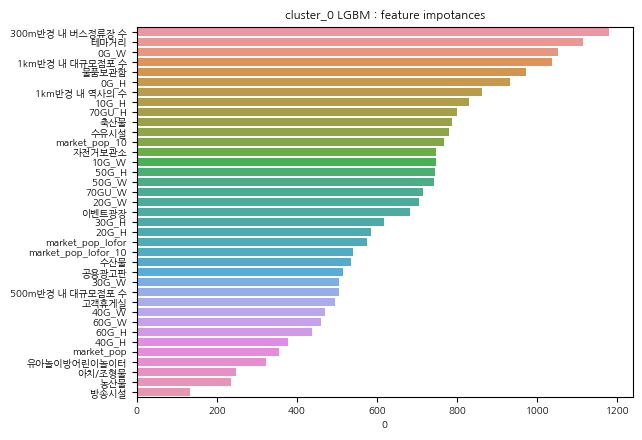

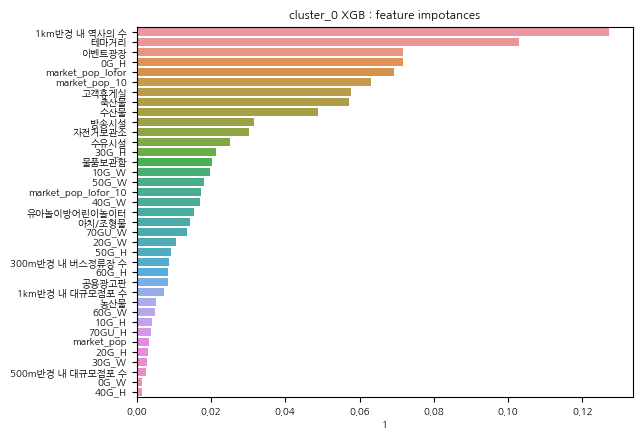

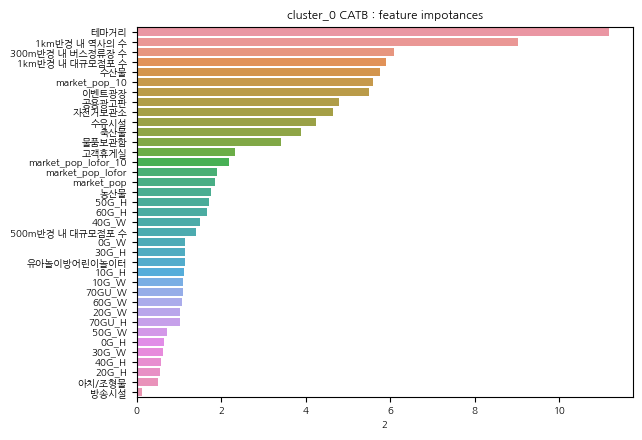

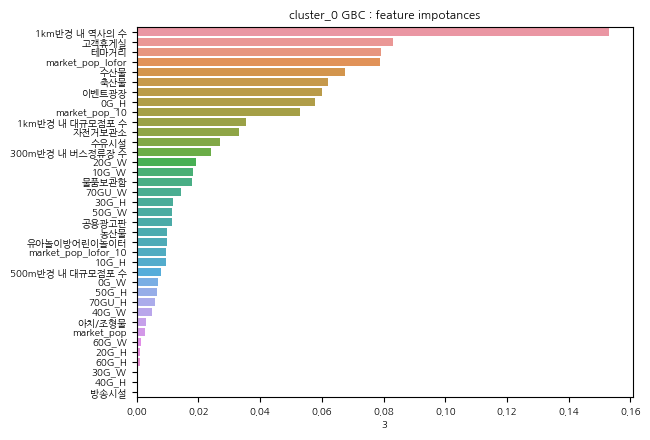

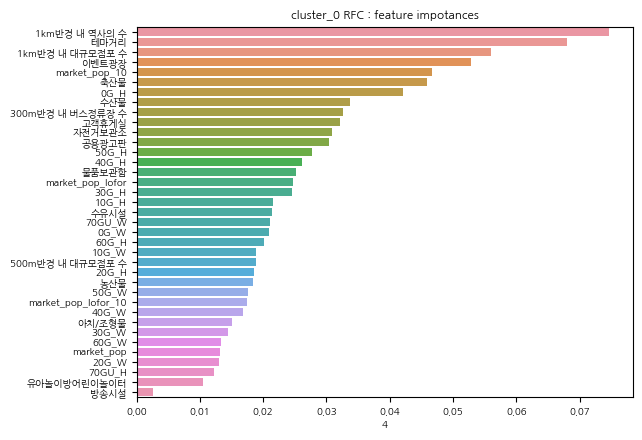

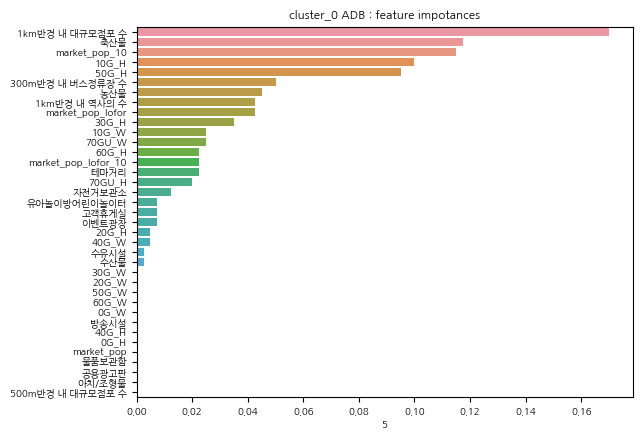

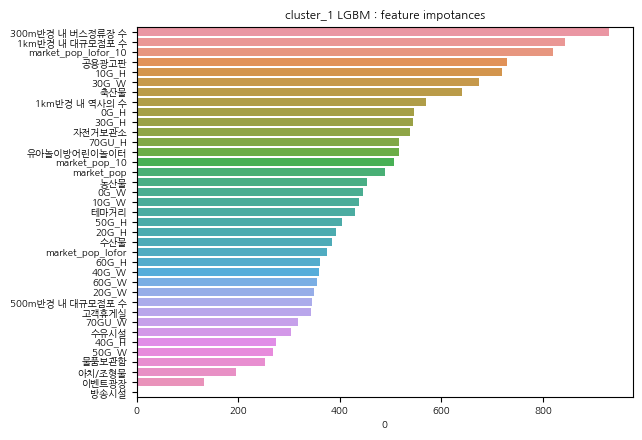

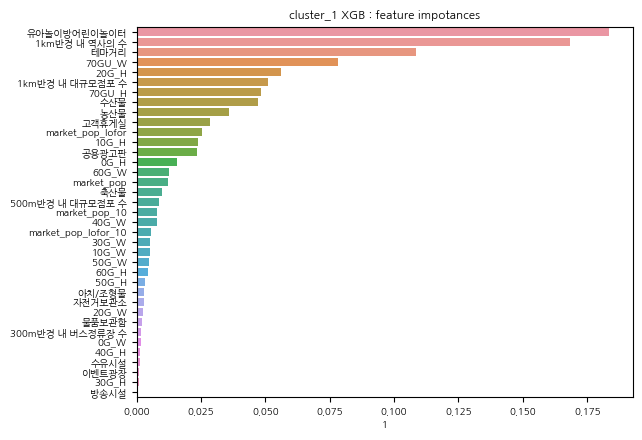

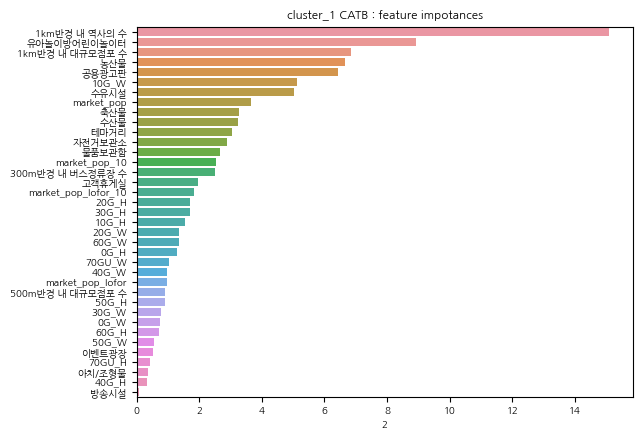

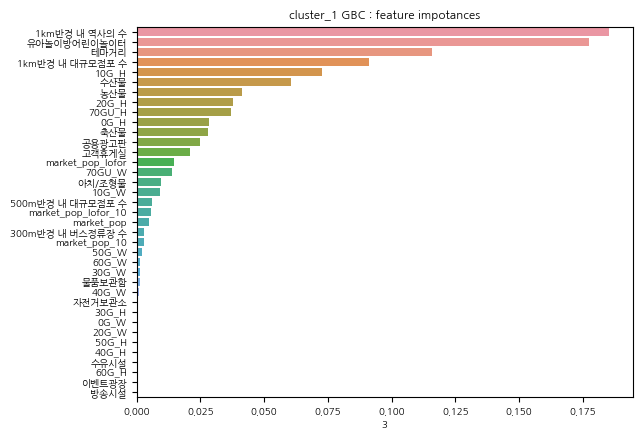

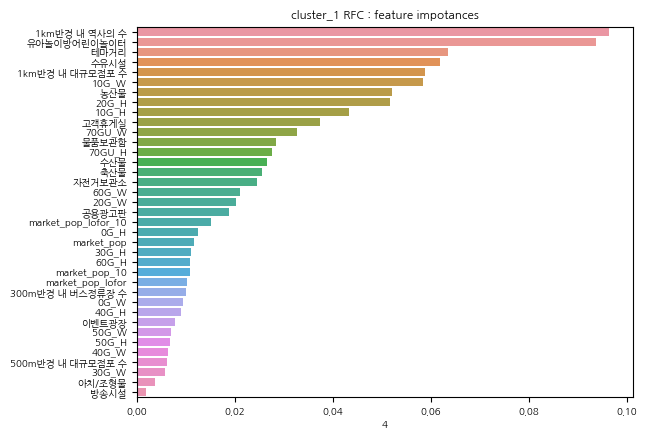

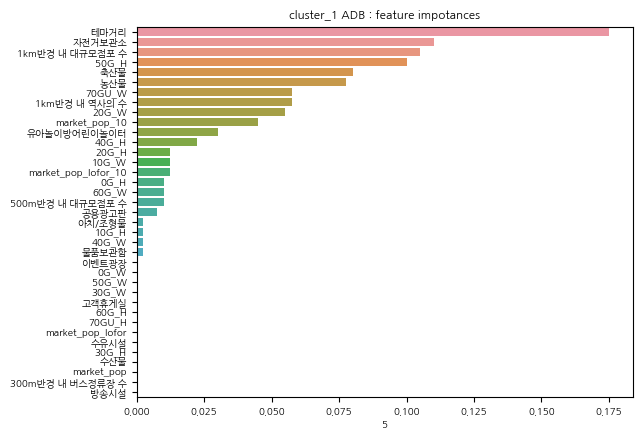

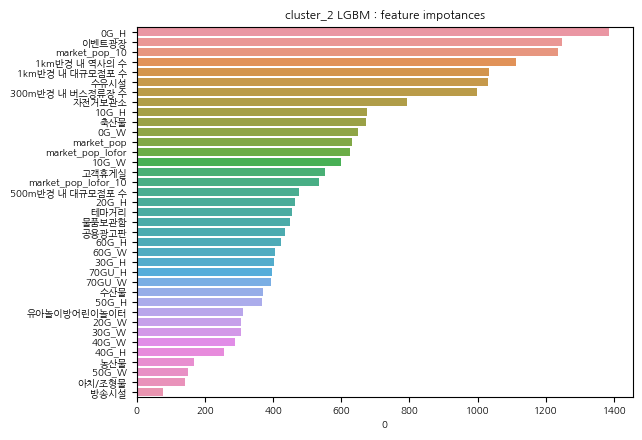

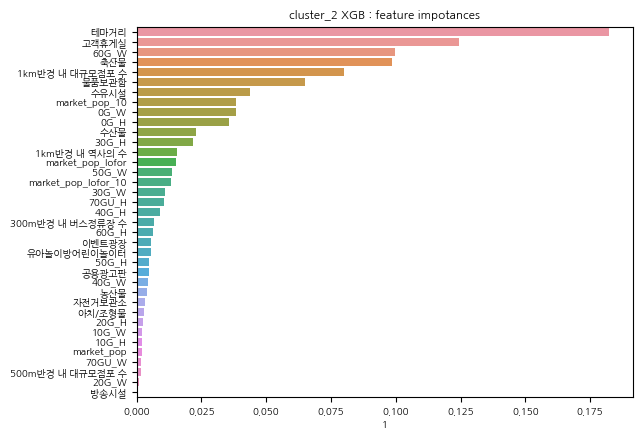

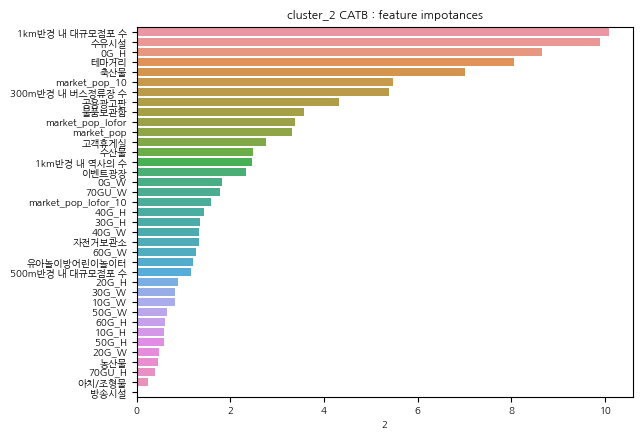

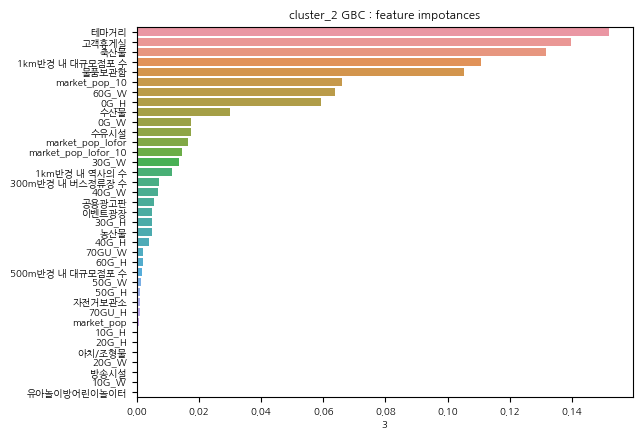

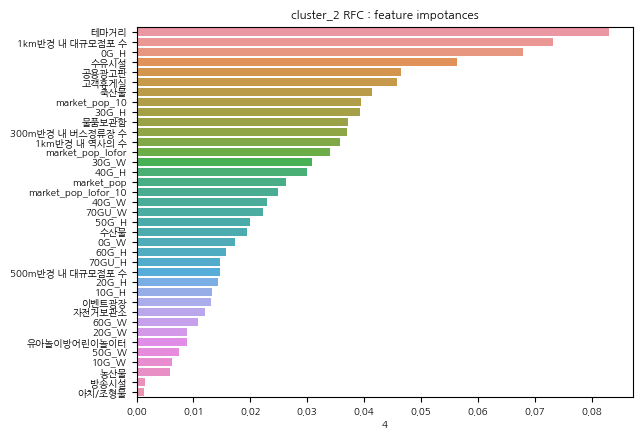

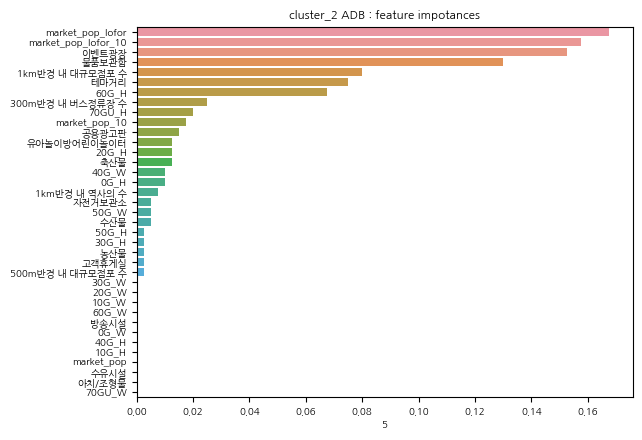

In [79]:
for d in data_list:
    data = pd.read_csv(d)
    feature_EDA(data)

In [80]:
data = pd.read_csv(data_list[2])
print(data['model'])
data['score']



0    cluster_2 LGBM
1     cluster_2 XGB
2    cluster_2 CATB
3     cluster_2 GBC
4     cluster_2 RFC
5     cluster_2 ADB
Name: model, dtype: object


0    0.842857
1    0.871429
2    0.871429
3    0.885714
4    0.914286
5    0.842857
Name: score, dtype: float64

In [21]:
def cluster_feature_rank(data):
    feature_rank = []
    for i in range(len(data)):
        ranked = pd.Series(data.iloc[i,1:-2]).rank(ascending=False)
        feature_rank.append(list(ranked))

    feature_rank = pd.DataFrame(feature_rank)
    feature_rank.index = data['model']
    feature_rank.columns = data.columns[1:-2]
    return feature_rank

In [22]:
cluster_name = []
for i in data_list:
    cluster_name.append(i.split('.')[0])
    
cluster_name

['result_cluster_0', 'result_cluster_1', 'result_cluster_2']

In [23]:
cluster_rank = []

for d in data_list:
    data = pd.read_csv(d)
    feature_rank = cluster_feature_rank(data)
    cluster_rank.append(list(round(np.mean(feature_rank),1)))
    
cluster_rank = pd.DataFrame(cluster_rank)
cluster_rank.index = cluster_name
cluster_rank.columns = data.columns[1:-2]
cluster_rank #순위는 숫자가 낮은게 중요도가 큰 것

,방송시설,이벤트광장,테마거리,아치/조형물,공용광고판,유아놀이방어린이놀이터,고객휴게실,수유시설,물품보관함,자전거보관소,...,60G_H,70GU_H,0G_W,10G_W,20G_W,30G_W,40G_W,50G_W,60G_W,70GU_W
result_cluster_0,31.5,9.8,4.0,30.3,20.3,25.7,13.2,14.6,15.5,12.0,...,24.2,24.8,23.2,17.4,24.7,31.8,24.4,23.3,30.3,18.9
result_cluster_1,35.9,33.4,6.7,28.4,12.0,5.2,18.1,23.4,22.8,16.2,...,28.2,17.6,27.9,14.0,22.5,24.6,25.2,28.9,20.2,15.2
result_cluster_2,35.6,14.8,5.3,33.8,14.7,26.3,10.0,10.2,9.0,22.3,...,21.2,23.3,16.6,29.1,32.6,22.4,21.6,26.2,19.6,25.1


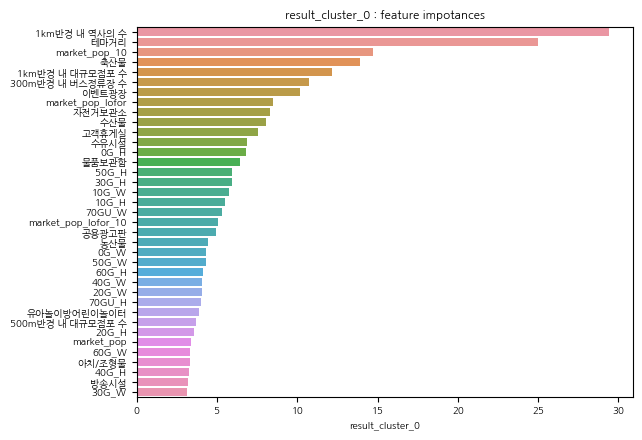

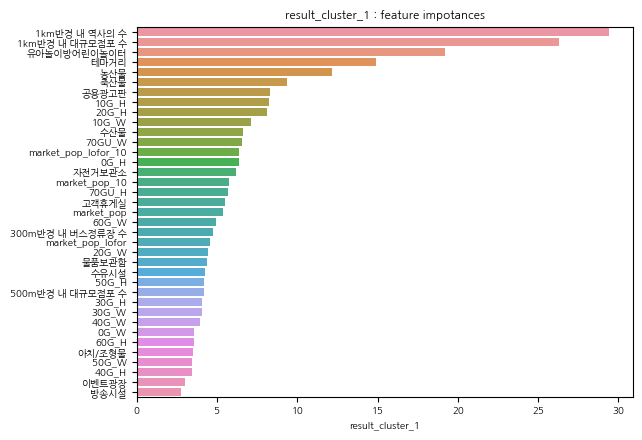

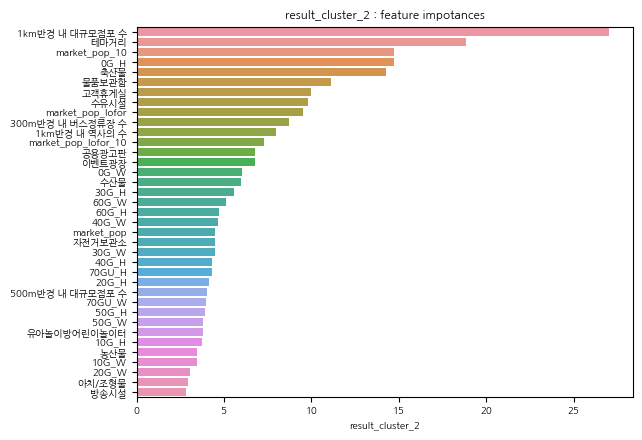

In [24]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.size'] = 7

import seaborn as sns

# #sns.barplot(x=data['score'], y=data['model'])
# sns.barplot(x=data['model'], y=data['score'])

for i in range(len(cluster_rank)):
    title = cluster_rank.index[i]
    feature_series=pd.Series(data=cluster_rank.iloc[i,:], index=cluster_rank.columns)
    #print(feature_series)
    feature_series=feature_series.sort_values(ascending=True)
    sns.barplot(x= 100/feature_series,y=feature_series.index) #시각화 할 때는 100/로 역수 취해줌 -> 숫자가 큰게 순위가 높은 것
    plt.title(f'{title} : feature impotances')
    plt.show()


In [59]:
#plot_importance()
#https://colab.research.google.com/github/parrt/dtreeviz/blob/master/notebooks/dtreeviz_sklearn_visualisations.ipynb#scrollTo=tsS_RzKjzr1B

### END OF SCRIPT